
# Step-by-Step Grid Search Labs (scikit-learn)

**Constraints (as requested):**
- ✅ Focus only on Grid Search
- ✅ Use `train_test_split` for the hold-out test set
- ✅ **No** `Pipeline`
- ✅ **No** user-defined functions or classes
- ✅ **No** `for` loops (all search is handled by `GridSearchCV` internally)

**What you’ll practice:**
- How to split data once (train/test), then run `GridSearchCV` **only on the training set**
- How to build a parameter grid for each model
- How to evaluate the best model on the hold-out test set

> 📌 Tip: Each lab is independent. Run them in order or jump to any section.


## 0) Common Setup (Run once)

In [1]:

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)



## 1) Classification — Logistic Regression (Breast Cancer dataset)

### Parameters to tune (and why)
- **`C`**: Inverse of regularization strength (smaller = stronger regularization). Controls overfitting.
- **`penalty`**: Type of regularization. We use `'l2'` (stable, widely supported).
- **`solver`**: Optimization algorithm (`'liblinear'`, `'lbfgs'`, `'saga'`); different solvers work better for different data sizes.
- **`max_iter`**: Upper bound on iterations; larger values help solvers converge.
- **`class_weight`**: `None` vs `'balanced'` can help when classes are imbalanced.


Best params: {'C': 10, 'class_weight': 'balanced', 'max_iter': 10000, 'penalty': 'l1', 'random_state': 42, 'solver': 'liblinear'}
CV best score (accuracy): 0.9626373626373625
Test accuracy: 0.9649122807017544
              precision    recall  f1-score   support

           0       0.93      0.98      0.95        42
           1       0.99      0.96      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.97      0.96       114
weighted avg       0.97      0.96      0.97       114



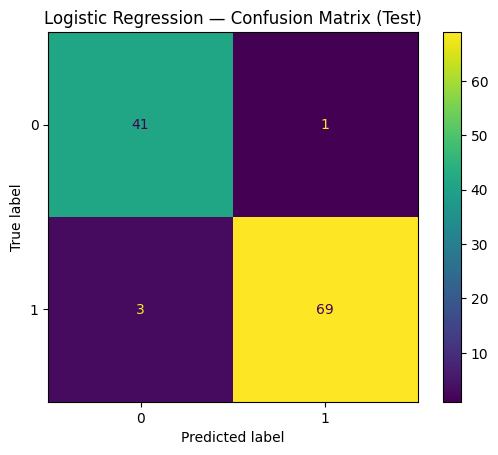

In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# --- data ---
X, y = load_breast_cancer(return_X_y=True)
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# --- model & grid (NO PIPELINE, NO SCALING) ---
# Use liblinear only (handles small/medium datasets well; less sensitive to feature scale)
# Allow both L1/L2 penalties; bump max_iter to ensure convergence
param_grid = {
    'solver': ['liblinear'],      # drop lbfgs/saga to avoid most convergence issues without scaling
    'penalty': ['l1', 'l2'],      # liblinear supports both
    'C': [0.01, 0.1, 1, 10, 100],
    'class_weight': [None, 'balanced'],
    'max_iter': [10000],          # give it room to converge
    'random_state': [RANDOM_STATE]
}

model = LogisticRegression()
search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    return_train_score=True
)
search.fit(X_train, y_train)

print('Best params:', search.best_params_)
print('CV best score (accuracy):', search.best_score_)

best_model = search.best_estimator_
y_pred = best_model.predict(X_test)
print('Test accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)
plt.title('Logistic Regression — Confusion Matrix (Test)')
plt.show()



**Exercises**
- Try `penalty=['l1','l2']` with `solver=['liblinear','saga']` (L1 needs a compatible solver).
- Add `tol=[1e-4, 1e-3]` to stabilize convergence in tough cases.



## 2) Classification — Support Vector Classifier (Iris) with manual scaling

### Why scaling?
SVMs are sensitive to feature scales. We’ll use `StandardScaler` manually (no pipeline) — **fit on train**, **transform train & test**.

### Parameters to tune (and why)
- **`kernel`**: `'linear'`, `'rbf'`, `'poly'`; decides decision boundary shape.
- **`C`**: Regularization (higher C tries to fit training data more).
- **`gamma`**: For `'rbf'`/`'poly'`, controls influence range of single training examples.
- **`degree`**: Only relevant for `'poly'` kernel.


Best params: {'C': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
CV best score (accuracy): 0.975
Test accuracy: 0.9333333333333333


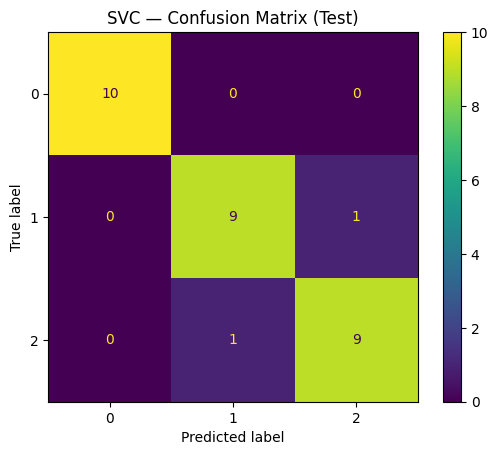

In [3]:

from sklearn.datasets import load_iris
from sklearn.svm import SVC

X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3]
}

model = SVC()
search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    return_train_score=True
)
search.fit(X_train_scaled, y_train)

print('Best params:', search.best_params_)
print('CV best score (accuracy):', search.best_score_)

best_model = search.best_estimator_
print('Test accuracy:', best_model.score(X_test_scaled, y_test))

ConfusionMatrixDisplay.from_estimator(best_model, X_test_scaled, y_test)
plt.title('SVC — Confusion Matrix (Test)')
plt.show()



**Exercises**
- Add `coef0` (affects `'poly'` kernel) to the grid.
- Compare results **with** and **without** scaling (replace scaled arrays by raw `X_train`, `X_test`).



## 3) Classification — KNN (Wine) with manual scaling

### Parameters to tune (and why)
- **`n_neighbors`**: Neighbor count; small = high variance, large = high bias.
- **`weights`**: `'uniform'` or `'distance'`; whether closer neighbors weigh more.
- **`metric`**: Distance metric; `'minkowski'` with `p=2` equals Euclidean.


Best params: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'uniform'}
CV best score (accuracy): 0.9859605911330049
Test accuracy: 1.0


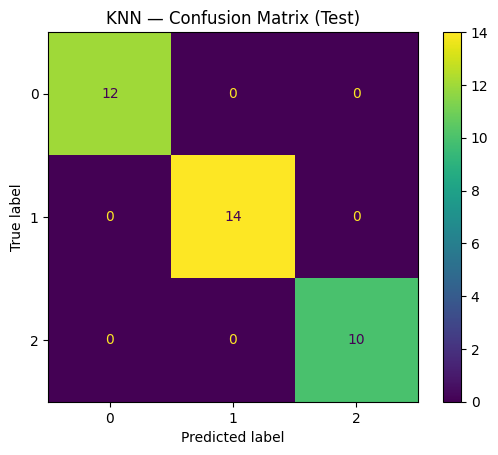

In [4]:

from sklearn.datasets import load_wine
from sklearn.neighbors import KNeighborsClassifier

X, y = load_wine(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid = {
    'n_neighbors': [3, 5, 7, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski', 'euclidean', 'manhattan']
}

model = KNeighborsClassifier()
search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    return_train_score=True
)
search.fit(X_train_scaled, y_train)

print('Best params:', search.best_params_)
print('CV best score (accuracy):', search.best_score_)

best_model = search.best_estimator_
print('Test accuracy:', best_model.score(X_test_scaled, y_test))

ConfusionMatrixDisplay.from_estimator(best_model, X_test_scaled, y_test)
plt.title('KNN — Confusion Matrix (Test)')
plt.show()



**Exercises**
- Add `p=[1, 2]` to compare Manhattan vs Euclidean for `'minkowski'`.
- Expand neighbor range (e.g., `[1, 3, 5, 9, 15, 25]`).



## 4) Classification — Random Forest (Wine)

### Parameters to tune (and why)
- **`n_estimators`**: Number of trees; more trees usually improve stability.
- **`max_depth`**: Tree depth; controls complexity/overfitting.
- **`min_samples_split`**, **`min_samples_leaf`**: Minimum samples to split/at leaves; regularization knobs.
- **`max_features`**: Subset of features tried at each split; can reduce correlation between trees.
- **`class_weight`**: Helps with imbalance.


Best params: {'class_weight': None, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
CV best score (accuracy): 0.9862068965517242
Test accuracy: 1.0


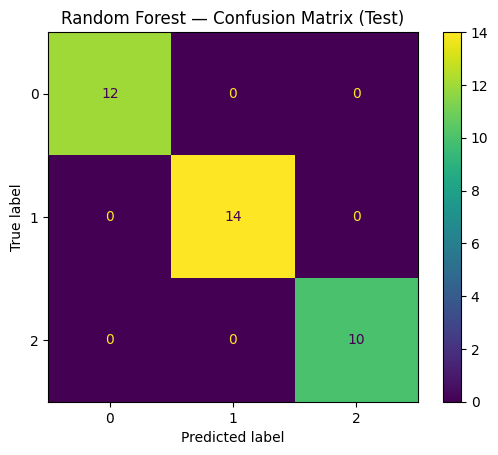

In [5]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_wine

X, y = load_wine(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 1.0],
    'class_weight': [None, 'balanced']
}

model = RandomForestClassifier(random_state=RANDOM_STATE)
search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    return_train_score=True
)
search.fit(X_train, y_train)

print('Best params:', search.best_params_)
print('CV best score (accuracy):', search.best_score_)

best_model = search.best_estimator_
print('Test accuracy:', best_model.score(X_test, y_test))

ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)
plt.title('Random Forest — Confusion Matrix (Test)')
plt.show()



**Exercises**
- Add `bootstrap=[True, False]` to understand bagging effects.
- Compare `'max_features'` choices for accuracy and speed.



## 5) Regression — Ridge (Diabetes)

### Parameters to tune (and why)
- **`alpha`**: Regularization strength (larger = stronger regularization).
- **`solver`**: Algorithm to fit coefficients; different solvers have different speed/precision trade-offs (`'auto'`, `'svd'`, `'cholesky'`, `'lsqr'`, `'sparse_cg'`, `'sag'`, `'saga'`).
- **`fit_intercept`**: Whether to learn the intercept.


In [7]:
# Full Ridge + GridSearchCV example (version-compatible)
# - Uses scoring='neg_mean_squared_error' for broad sklearn compatibility
# - Computes RMSE via np.sqrt(mean_squared_error) to avoid 'squared=False' arg

from sklearn.datasets import load_diabetes
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Reproducibility
RANDOM_STATE = 42

# 1) Load data
X, y = load_diabetes(return_X_y=True)

# 2) Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

# 3) Define search space
param_grid = {
    "alpha": [0.01, 0.1, 1, 10, 100],
    "solver": ["auto", "svd", "cholesky", "lsqr", "sparse_cg", "sag", "saga"],
    "fit_intercept": [True, False],
}

# 4) Set up model & grid search
model = Ridge(random_state=RANDOM_STATE) if "random_state" in Ridge().get_params() else Ridge()
search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",  # compatible across many sklearn versions
    cv=5,
    n_jobs=-1,
    return_train_score=True,
)

# 5) Fit
search.fit(X_train, y_train)

# 6) Report CV results (convert neg MSE -> RMSE)
best_params = search.best_params_
best_neg_mse = search.best_score_                  # negative MSE
best_cv_rmse = np.sqrt(-best_neg_mse)              # RMSE

print("Best params:", best_params)
print("CV best score (RMSE):", best_cv_rmse)

# 7) Evaluate on test set
best_model = search.best_estimator_
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)           # plain MSE
rmse = np.sqrt(mse)                                # RMSE
r2 = r2_score(y_test, y_pred)

print("Test RMSE:", rmse)
print("Test R^2:", r2)


Best params: {'alpha': 0.1, 'fit_intercept': True, 'solver': 'lsqr'}
CV best score (RMSE): 55.90283801094393
Test RMSE: 53.44836529536603
Test R^2: 0.4608067325465477



**Exercises**
- Add `alpha` values on a log scale (`[1e-4, 1e-3, ..., 1e2]`).
- Compare `Ridge` vs `Lasso` (next lab) on the same data.



## 6) Regression — Lasso (Diabetes)

### Parameters to tune (and why)
- **`alpha`**: L1 regularization strength (induces sparsity; can zero-out coefficients).
- **`max_iter`**: More iterations can help convergence with small `alpha`.
- **`selection`**: `'cyclic'` vs `'random'` coordinate updates; may affect speed/solution.


In [9]:
from sklearn.datasets import load_diabetes
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Reproducibility for the train/test split (Lasso itself is deterministic unless selection='random')
RANDOM_STATE = 42

# 1) Data
X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

# 2) Hyperparameter grid
param_grid = {
    "alpha": [0.001, 0.01, 0.1, 1.0],
    "max_iter": [1000, 5000, 10000],
    "selection": ["cyclic", "random"],
}

# 3) Model & search (use neg MSE for broad compatibility)
model = Lasso()
search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",   # use neg MSE; convert to RMSE later
    cv=5,
    n_jobs=-1,
    return_train_score=True,
)
search.fit(X_train, y_train)

# 4) Report CV (convert neg MSE -> RMSE so bigger-is-better becomes smaller-is-better intuition)
best_neg_mse = search.best_score_
best_cv_rmse = np.sqrt(-best_neg_mse)
print("Best params:", search.best_params_)
print("CV best score (RMSE):", best_cv_rmse)

# 5) Test evaluation
best_model = search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print("Test RMSE:", rmse)
print("Test R^2:", r2)


Best params: {'alpha': 0.1, 'max_iter': 1000, 'selection': 'random'}
CV best score (RMSE): 55.93638114676728
Test RMSE: 52.89828853808879
Test R^2: 0.4718480966419363



**Exercises**
- Add smaller `alpha` (e.g., `0.0001`) and increase `max_iter`.
- Compare selected features (non-zero coefficients) between best `Ridge` and best `Lasso`.



## 7) Regression — Decision Tree Regressor (Diabetes)

### Parameters to tune (and why)
- **`max_depth`**: Controls tree depth and overfitting.
- **`min_samples_split`**, **`min_samples_leaf`**: Regularize tree growth.
- **`criterion`**: Split quality metric (e.g., `'squared_error'`, `'absolute_error'`).


In [14]:
# --- imports ---
import numpy as np
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

# --- config ---
RANDOM_STATE = 42

# --- data ---
X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

# --- grid ---
param_grid = {
    'max_depth': [None, 3, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['squared_error', 'absolute_error']
}

model = DecisionTreeRegressor(random_state=RANDOM_STATE)

search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',  # closer to 0 = better
    cv=5,
    n_jobs=-1,
    return_train_score=True
)

# --- training ---
search.fit(X_train, y_train)

print('Best params:', search.best_params_)
print('CV best score (neg RMSE):', search.best_score_)

# --- evaluate on test set ---
best_model = search.best_estimator_
y_pred = best_model.predict(X_test)

# compute RMSE manually for compatibility
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Test RMSE:', rmse)

# compute R^2
print('Test R^2:', r2_score(y_test, y_pred))


Best params: {'criterion': 'squared_error', 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2}
CV best score (neg RMSE): -64.32353433046526
Test RMSE: 58.228715014669916
Test R^2: 0.36004414120283446



**Exercises**
- Add `max_features=['sqrt', 'log2', None]`.
- Visualize the tree depth vs test RMSE by manually editing the grid values (still no loops required).



## 8) Regression — Random Forest Regressor (Diabetes)

### Parameters to tune (and why)
- **`n_estimators`**: Number of trees; more can improve stability.
- **`max_depth`**, **`min_samples_split`**, **`min_samples_leaf`**: Control complexity.
- **`max_features`**: Features considered at each split (e.g., `'sqrt'`, `'log2'`, or a float fraction).


In [15]:
# --- imports ---
import numpy as np
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# --- config ---
RANDOM_STATE = 42

# --- data ---
X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

# --- grid ---
param_grid = {
    'n_estimators': [200, 400],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2', 1.0],
}

# --- model & search ---
model = RandomForestRegressor(random_state=RANDOM_STATE)
search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',  # CV metric
    cv=5,
    n_jobs=-1,
    return_train_score=True
)
search.fit(X_train, y_train)

print('Best params:', search.best_params_)
print('CV best score (neg RMSE):', search.best_score_)
print('CV best RMSE:', -search.best_score_)

# --- evaluate on test set ---
best_model = search.best_estimator_
y_pred = best_model.predict(X_test)

# Compute RMSE manually (works on all sklearn versions)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Test RMSE:', rmse)

print('Test R^2:', r2_score(y_test, y_pred))


Best params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 400}
CV best score (neg RMSE): -57.53043799593669
CV best RMSE: 57.53043799593669
Test RMSE: 53.42279835610717
Test R^2: 0.4613224536280297
